# Digital KYC Drop-Off Reduction & Conversion Improvement

This notebook loads the provided Excel sheet `Digital KYC_Reduce Drop-Off_Lift Conversion.xlsx`, performs data cleaning, exploratory data analysis (EDA), visualizations, and computes KPIs and suggested actionable metrics aligned to the recommendations in the report. Run the cells sequentially.

In [1]:
# Imports and configuration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)

In [3]:
# Path to the uploaded Excel file (adjust if different)
EXCEL_PATH = r'D:\Capstone Project\Updated Problem Statement Packs\1. Digital KYC Reduce Drop-Off Lift Conversion\Digital KYC_Reduce Drop-Off_Lift Conversion.xlsx'

In [4]:
# Load the workbook and preview sheet names
xls = pd.ExcelFile(EXCEL_PATH)
print('Sheets found:', xls.sheet_names)

Sheets found: ['Digital KYC Data Dump']


In [5]:
# Load the first sheet (assumed to be the data dump)
sheet_name = xls.sheet_names[0]
df_raw = xls.parse(sheet_name)

print('\nRaw head:')
df_raw.head()


Raw head:


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,S.No.,Customer ID,Stage Name,Attempt Count,Failure Percentage,Time Taken (in seconds),Error
1,NaN,1,2815597,Upload Document,1,0.15,16,Upload the Selected Document
2,NaN,2,2738532,Document Scan,3,0.3,39,Please scan the correct document
3,NaN,3,4110529,Document Scan,2,0.2,25,Please scan the correct document
4,NaN,4,2992473,KYC Check,3,0.3,32,KYC data not found; please upload correct KYC


## Data Cleaning and Normalization

The uploaded file appears to contain unnamed columns and header rows. We'll inspect and clean.

In [6]:
df = df_raw.copy()

In [7]:
# Inspect column names
print('Original columns:')
print(df.columns.tolist())

Original columns:
['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7']


In [8]:
# If the file includes header information in the first row, promote it
# Detect if the first row contains strings like 'S.No.' or 'Customer ID'
first_row = df.iloc[0].astype(str).str.lower().tolist()
print('\nFirst row sample values (lowercased):')
print(first_row)


First row sample values (lowercased):
['nan', 's.no.', 'customer id', 'stage name', 'attempt count', 'failure percentage', 'time taken (in seconds)', 'error']


In [9]:
# Heuristics: if first row contains 's.no' or 'customer id', use it as header
if any('s.no' in str(x) or 'customer' in str(x) for x in first_row):
    df.columns = df.iloc[0].values
    df = df[1:].reset_index(drop=True)

In [10]:
# Clean column names: strip and replace spaces
clean_cols = [str(c).strip() for c in df.columns]
clean_cols = [c.replace('\n', ' ').replace(' ', '_') for c in clean_cols]
df.columns = clean_cols
print('\nClean columns:')
print(df.columns.tolist())


Clean columns:
['nan', 'S.No.', 'Customer_ID', 'Stage_Name', 'Attempt_Count', 'Failure_Percentage', 'Time_Taken_(in_seconds)', 'Error']


In [11]:
# Preview cleaned head
print('\nCleaned head:')
df.head()


Cleaned head:


,nan,S.No.,Customer_ID,Stage_Name,Attempt_Count,Failure_Percentage,Time_Taken_(in_seconds),Error
0,NaN,1,2815597,Upload Document,1,0.15,16,Upload the Selected Document
1,NaN,2,2738532,Document Scan,3,0.3,39,Please scan the correct document
2,NaN,3,4110529,Document Scan,2,0.2,25,Please scan the correct document
3,NaN,4,2992473,KYC Check,3,0.3,32,KYC data not found; please upload correct KYC
4,NaN,5,4205534,KYC Approved,1,0,15,KYC Successful


## Standardize and rename known columns for clarity

In [12]:
# Try to find best matches for columns we expect
col_map = {}
col_text = ' '.join(df.columns.tolist()).lower()

In [13]:
# mapping heuristics
if any('customer' in c.lower() for c in df.columns):
    for c in df.columns:
        if 'customer' in c.lower():
            col_map[c] = 'customer_id'
        if 'stage' in c.lower():
            col_map[c] = 'stage_name'
        if 'attempt' in c.lower():
            col_map[c] = 'attempt_count'
        if 'failure' in c.lower():
            col_map[c] = 'failure_percentage'
        if 'time' in c.lower():
            col_map[c] = 'time_taken_seconds'
        if 'error' in c.lower():
            col_map[c] = 'error_message'

In [14]:
# Apply rename
df = df.rename(columns=col_map)
print('Renamed columns:')
print(df.columns.tolist())

Renamed columns:
['nan', 'S.No.', 'customer_id', 'stage_name', 'attempt_count', 'failure_percentage', 'time_taken_seconds', 'error_message']


In [15]:
# Convert numeric fields to appropriate types
for col in ['attempt_count', 'failure_percentage', 'time_taken_seconds']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [16]:
# Strip whitespace on stage and error message
if 'stage_name' in df.columns:
    df['stage_name'] = df['stage_name'].astype(str).str.strip()
if 'error_message' in df.columns:
    df['error_message'] = df['error_message'].astype(str).str.strip()

In [17]:
# Drop fully empty rows (if any)
df = df.dropna(how='all').reset_index(drop=True)

print('\nData types after cleaning:')
print(df.dtypes)


Data types after cleaning:
nan                   float64
S.No.                  object
customer_id            object
stage_name             object
attempt_count           int64
failure_percentage    float64
time_taken_seconds      int64
error_message          object
dtype: object


## Quick sanity checks and summary

In [18]:
print('Number of records:', len(df))
print('\nStage distribution:')
display(df['stage_name'].value_counts(dropna=False))

Number of records: 400

Stage distribution:


Document Scan           140
Upload Document         100
KYC Check                60
Select Document Type     60
KYC Approved             40
Name: stage_name, dtype: int64

In [19]:
# Show time and failure distributions if present
if 'failure_percentage' in df.columns:
    print('\nFailure percentage summary:')
    display(df['failure_percentage'].describe())
if 'time_taken_seconds' in df.columns:
    print('\nTime taken (seconds) summary:')
    display(df['time_taken_seconds'].describe())


Failure percentage summary:


count    400.000000
mean       0.231347
std        0.157392
min        0.000000
25%        0.100000
50%        0.200000
75%        0.300000
max        0.642857
Name: failure_percentage, dtype: float64


Time taken (seconds) summary:


count    400.00000
mean      30.24750
std        9.16932
min       10.00000
25%       23.00000
50%       31.00000
75%       38.00000
max       48.00000
Name: time_taken_seconds, dtype: float64

## Exploratory Visualizations


Failure % by Stage (summary):


,stage_name,count,mean,median
2,KYC Check,60,0.468333,0.400000
4,Upload Document,100,0.241886,0.238421
0,Document Scan,140,0.220714,0.200000
3,Select Document Type,60,0.114167,0.100000
1,KYC Approved,40,0.062500,0.000000


<Figure size 800x500 with 0 Axes>

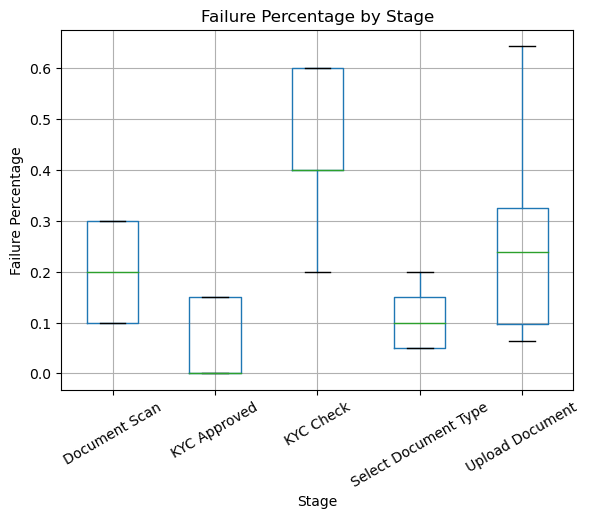

In [20]:
# 1) Failure percentage by stage (boxplot / mean)
if 'stage_name' in df.columns and 'failure_percentage' in df.columns:
    agg = df.groupby('stage_name')['failure_percentage'].agg(['count', 'mean', 'median']).reset_index()
    print('\nFailure % by Stage (summary):')
    display(agg.sort_values('mean', ascending=False))

    plt.figure(figsize=(8,5))
    df.boxplot(column='failure_percentage', by='stage_name')
    plt.title('Failure Percentage by Stage')
    plt.suptitle('')
    plt.xlabel('Stage')
    plt.ylabel('Failure Percentage')
    plt.xticks(rotation=30)
    plt.show()

<Figure size 800x500 with 0 Axes>

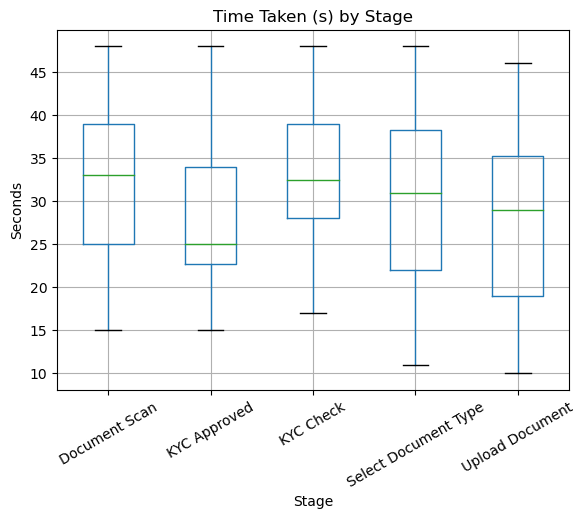

In [21]:
# 2) Time taken by stage
if 'stage_name' in df.columns and 'time_taken_seconds' in df.columns:
    plt.figure(figsize=(8,5))
    df.boxplot(column='time_taken_seconds', by='stage_name')
    plt.title('Time Taken (s) by Stage')
    plt.suptitle('')
    plt.xlabel('Stage')
    plt.ylabel('Seconds')
    plt.xticks(rotation=30)
    plt.show()

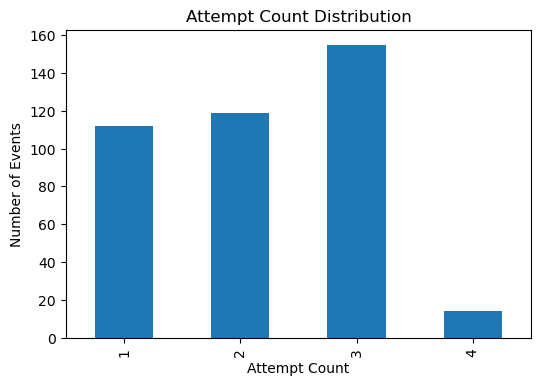

In [22]:
# 3) Attempts distribution
if 'attempt_count' in df.columns:
    plt.figure(figsize=(6,4))
    df['attempt_count'].value_counts().sort_index().plot(kind='bar')
    plt.title('Attempt Count Distribution')
    plt.xlabel('Attempt Count')
    plt.ylabel('Number of Events')
    plt.show()

## Error Message Analysis

In [23]:
if 'error_message' in df.columns:
    # Normalize messages to lowercase and simple mapping
    df['error_norm'] = df['error_message'].str.lower().str.replace('[^a-z0-9 ]','', regex=True)
    # Get top error phrases
    top_errors = df['error_norm'].value_counts().head(20)
    print('\nTop error messages:')
    display(top_errors)

    # Create categorized error buckets heuristically
    def categorize_error(msg):
        if pd.isna(msg) or str(msg).strip()=='' or str(msg).lower()=='nan':
            return 'unknown'
        m = msg.lower()
        if 'scan' in m or 'blurry' in m or 'please scan' in m or 'scan the correct' in m:
            return 'scan_issue'
        if 'upload' in m:
            return 'upload_issue'
        if 'kyc data not found' in m or 'duplicate' in m:
            return 'backend_kyc_issue'
        if 'photo' in m or 'selfie' in m or 'match' in m:
            return 'photo_mismatch'
        return 'other'

    df['error_category'] = df['error_norm'].apply(categorize_error)
    print('\nError category counts:')
    display(df['error_category'].value_counts())


Top error messages:


please scan the correct document                         104
please upload the correct selected document               59
kyc successful                                            40
please select correct document type                       39
proceed to document upload                                36
kyc data not found please upload correct kyc              34
upload the selected document                              32
kyc document already exists please upload correct kyc     19
select document type  pan aadhar voter                    16
maximum tries exceeded                                     9
kyc check in progress please wait                          7
maximum upload tries exceeded                              5
Name: error_norm, dtype: int64


Error category counts:


upload_issue    185
other           111
scan_issue      104
Name: error_category, dtype: int64

## KPI Computation and Reporting

In [24]:
# KPIs defined in the report: failure % per stage, avg time per stage, avg attempts per stage
kpi = None
if 'stage_name' in df.columns:
    kpi = df.groupby('stage_name').agg(
        events=('stage_name','count'),
        avg_failure_pct=('failure_percentage','mean'),
        median_failure_pct=('failure_percentage','median'),
        avg_time_s=('time_taken_seconds','mean'),
        median_attempts=('attempt_count','median')
    ).reset_index()
    print('\nStage-level KPIs:')
    display(kpi.sort_values('avg_failure_pct', ascending=False))


Stage-level KPIs:


,stage_name,events,avg_failure_pct,median_failure_pct,avg_time_s,median_attempts
2,KYC Check,60,0.468333,0.400000,33.150000,2.0
4,Upload Document,100,0.241886,0.238421,27.560000,2.0
0,Document Scan,140,0.220714,0.200000,31.621429,2.0
3,Select Document Type,60,0.114167,0.100000,30.400000,2.0
1,KYC Approved,40,0.062500,0.000000,27.575000,1.0


In [25]:
# Save KPI table to CSV for use in dashboards
OUT_DIR = '/mnt/data/digital_kyc_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
if kpi is not None:
    kpi.to_csv(os.path.join(OUT_DIR, 'kyc_stage_kpis.csv'), index=False)
    print('Saved KPIs to', os.path.join(OUT_DIR, 'kyc_stage_kpis.csv'))

Saved KPIs to /mnt/data/digital_kyc_outputs\kyc_stage_kpis.csv


## Actionable Insights (computed heuristics)

In [27]:
insights = []
# Insight: stages with mean failure over 0.20
if kpi is not None:
    high_fail = kpi[kpi['avg_failure_pct']>0.2]
    for _, row in high_fail.iterrows():
        insights.append(f"Stage '{row['stage_name']}' shows high average failure percentage ({row['avg_failure_pct']:.2f}). Recommend improved UI guidance and automated image checks.")
# Insight: stages with avg_time_s > 20
if kpi is not None:
    slow = kpi[kpi['avg_time_s']>20]
    for _, row in slow.iterrows():
        insights.append(f"Stage '{row['stage_name']}' has high average time ({row['avg_time_s']:.1f} s). Recommend backend optimization and caching.")

# Error category prevalence
if 'error_category' in df.columns:
    err_counts = df['error_category'].value_counts(normalize=True)
    if 'scan_issue' in err_counts and err_counts['scan_issue']>0.2:
        insights.append('Scan-related errors are a significant proportion of failures. Implement real-time blur/edge detection and auto-capture.')
    if 'upload_issue' in err_counts and err_counts['upload_issue']>0.1:
        insights.append('Upload issues are common. Add pre-upload format checks and retry/resume upload capabilities.')

print('\nActionable Insights:')
for i,ins in enumerate(insights,1):
    print(f"{i}. {ins}")


Actionable Insights:
1. Stage 'Document Scan' shows high average failure percentage (0.22). Recommend improved UI guidance and automated image checks.
2. Stage 'KYC Check' shows high average failure percentage (0.47). Recommend improved UI guidance and automated image checks.
3. Stage 'Upload Document' shows high average failure percentage (0.24). Recommend improved UI guidance and automated image checks.
4. Stage 'Document Scan' has high average time (31.6 s). Recommend backend optimization and caching.
5. Stage 'KYC Approved' has high average time (27.6 s). Recommend backend optimization and caching.
6. Stage 'KYC Check' has high average time (33.1 s). Recommend backend optimization and caching.
7. Stage 'Select Document Type' has high average time (30.4 s). Recommend backend optimization and caching.
8. Stage 'Upload Document' has high average time (27.6 s). Recommend backend optimization and caching.
9. Scan-related errors are a significant proportion of failures. Implement real-t

In [28]:
# Save insights to text
with open(os.path.join(OUT_DIR,'insights.txt'),'w') as f:
    for ins in insights:
        f.write(ins+'\n')
print('\nSaved insights to', os.path.join(OUT_DIR,'insights.txt'))


Saved insights to /mnt/data/digital_kyc_outputs\insights.txt


## Recommendation Generation (text file)

In [29]:
recommendations = []
recommendations.append('1. Improve Scan UX: Add real-time capture assistance, auto-capture when document edges and clarity are optimal, and show sample correct images.')
recommendations.append('2. Pre-Upload Validation: Enforce file size/type limits, pre-validate document fields (passport expiry), and warn user before backend submission.')
recommendations.append('3. Backend Optimization: Use caching, scaled OCR workers, and load-balancing to keep step time under 15 seconds.')
recommendations.append('4. Retry & Human Fallback: Replace hard auto-reject on 4th attempt with a human-assisted review queue and progressive in-app help.')
recommendations.append('5. Progress Tracker: Add a KYC progress UI to show completed/pending steps and clear next-step instructions.')

with open(os.path.join(OUT_DIR,'recommendations.txt'),'w') as f:
    for r in recommendations:
        f.write(r+'\n')
print('Saved recommendations to', os.path.join(OUT_DIR,'recommendations.txt'))

Saved recommendations to /mnt/data/digital_kyc_outputs\recommendations.txt


## Example: Export a short PDF/markdown summary

In [30]:
summary_md = []
summary_md.append('# Digital KYC: Automated Analysis Summary')
summary_md.append('\n## Key KPIs')
if kpi is not None:
    summary_md.append(kpi.to_markdown(index=False))
summary_md.append('\n## Actionable Insights')
for ins in insights:
    summary_md.append('- '+ins)
summary_md.append('\n## Recommendations')
for r in recommendations:
    summary_md.append('- '+r)

summary_text = '\n\n'.join(summary_md)
with open(os.path.join(OUT_DIR,'summary.md'),'w') as f:
    f.write(summary_text)
print('Saved summary to', os.path.join(OUT_DIR,'summary.md'))

Saved summary to /mnt/data/digital_kyc_outputs\summary.md
